In [782]:
!python --version

Python 3.8.10


In [783]:
!git clone https://github.com/kc-ml2/marlenv.git

fatal: destination path 'marlenv' already exists and is not an empty directory.


In [784]:
cd /content/marlenv/

/content/marlenv


In [785]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/marlenv
  Preparing metadata (setup.py) ... done
  Attempting uninstall: marlenv
    Found existing installation: marlenv 1.0.0test1
    Can't uninstall 'marlenv'. No files were found to uninstall.
  Running setup.py develop for marlenv


In [786]:
import gym
import marlenv
import marlenv.envs
from google.colab import files

custom_reward_func = {
    'fruit': 1.0,
    'kill': 20.0,
    'lose': -1.0,
    'time': 0.0,
    'win': 1.0
}
env = gym.make(
    'Snake-v1',
    # height=20,       # Height of the grid map
    # width=20,        # Width of the grid map
    # num_snakes=4,    # Number of snakes to spawn on grid
    # snake_length=3,  # Initial length of the snake at spawn time
    # vision_range=10,  # Vision range (both width height), map returned if None
    # frame_stack=1,   # Number of observations to stack on return
    # num_envs=2,
    height=20,
    width=20,
    num_snakes=4,
    num_fruits = 8,
    snake_length=3,
    vision_range=None,
    frame_stack=1,
    observer='snake',
    # full_observation=False,
    reward_func=custom_reward_func
)

# env = gym.make('Snake-v1', reward_func=custom_reward_func)


In [787]:
obs = env.reset()

In [788]:
obs.shape

(4, 20, 20, 8)

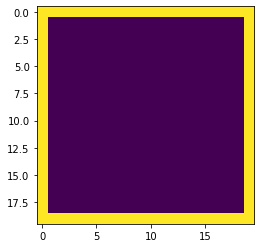

In [789]:
import matplotlib.pyplot as plt
plt.imshow(obs[0, :, :, 0]) #locations of the walls

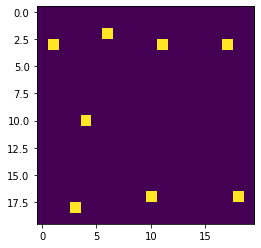

In [790]:
import matplotlib.pyplot as plt
plt.imshow(obs[0, :, :, 1]) #locations of the fruits

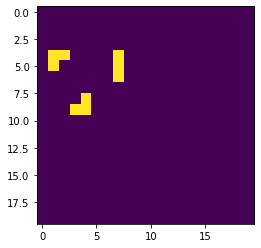

In [791]:
plt.imshow(obs[0, :, :, 2]+obs[0, :, :, 3]+obs[0, :, :, 4]) #locations of oppenents?

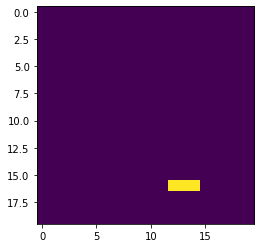

In [792]:
plt.imshow(obs[0, :, :, 5]+obs[0, :, :, 6]+obs[0, :, :, 7]) #locations of the snake itself？

In [793]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

class policy(nn.Module):
    """General policy model for calculating action policy from state."""
    def __init__(self):
        super(policy, self).__init__()
        self.actor = nn.Sequential(nn.Conv2d(8, 4, 2),
                                   nn.ReLU(),
                                   nn.Conv2d(4, 4, 2),
                                   nn.ReLU(),
                                   nn.Flatten(),
                                   nn.Linear(1296, 64),
                                   nn.ReLU(),
                                  #  nn.Linear(256, 64),
                                  #  nn.ReLU(),
                                  #  nn.Linear(64, 64),
                                  #  nn.ReLU(),
                                   nn.Linear(64, 3),
                                   nn.Softmax(dim=-1))

    def forward(self, state):
        mu = self.actor(state)
        return Categorical(mu)

class critic(nn.Module):
    """Critic model for estimating value from state."""
    def __init__(self):
        super(critic, self).__init__()

        self.critic = nn.Sequential(nn.Conv2d(8, 8, 2),
                                    nn.ReLU(),
                                    nn.Conv2d(8, 8, 2),
                                    nn.ReLU(),
                                    nn.Flatten(),
                                    nn.Linear(2592, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 1))

    def forward(self, state):
        value = self.critic(state)
        return value

In [794]:
import os
import copy
import pdb
import time
import numpy as np
import torch
import torch.autograd as autograd
import pdb

# TODO(yyshi): Casework for this?
DEFAULT_DTYPE = torch.float32
torch.set_default_dtype(DEFAULT_DTYPE)

def zero_grad(params):
    """Given some list of Tensors, zero and reset gradients."""
    for p in params:
        if p.grad is not None:
            p.grad.detach()
            p.grad.zero_()

def flatten_filter_none(grad_list, param_list,
                        detach=False,
                        neg=False,
                        device=torch.device('cpu')):
    """
    Given a list of Tensors with possible None values, returns single Tensor
    with None removed and flattened.
    """
    filtered = []
    for grad, param in zip(grad_list, param_list):
        if grad is None:
            filtered.append(torch.zeros(param.numel(), device=device, requires_grad=True))
        else:
            filtered.append(grad.contiguous().view(-1))

    result = torch.cat(filtered) if not neg else -torch.cat(filtered)

    # Use this only if higher order derivatives are not needed.
    if detach:
        result.detach()

    return result

# TODO(anonymous): make this user interface cleaner.
class SGD(object):
    """Optimizer class for simultaneous SGD"""
    def __init__(self, player_list,
                 lr_list=None,
                 device=torch.device('cpu')
                ):
        """
        :param player_list: list (per player) of list of Tensors, representing parameters
        :param lr_list: list of learning rates per player optimizer.
        """
        # Store optimizer state.
        player_list = [list(elem) for elem in player_list]
        self.state = {'step': 0,
                      'player_list': player_list,
                      'lr_list': lr_list}
        # TODO(anonymous): set this device in CMD algorithm.
        self.device = device

    def zero_grad(self):
        for player in self.state['player_list']:
            zero_grad(player)

    def state_dict(self):
        return self.state

    def step(self, loss_list):
        #print('loss function', loss_list)
        grad_list = [
            autograd.grad(loss, player, retain_graph=True, allow_unused=True)
            for loss, player in zip(loss_list, self.state['player_list'])
        ]

        # print("largest gradient:", max(torch.max(tensor) for tensor in grad_list[0]))
        # print("largest gradient:", max(torch.max(tensor) for tensor in grad_list[1]))
        # print("largest gradient:", max(torch.max(tensor) for tensor in grad_list[2]))



        for grad, player, lr in zip(grad_list, self.state['player_list'], self.state['lr_list']):
            for player_elem, grad_elem in zip(player, grad):
                if grad_elem is not None:
                    player_elem.data -= grad_elem * lr

def critic_update(mat_states, mat_action_mask, returns, q, optim_q, batch_size, trj_len, unflatten_state, device):
    counter = 0
    for j in range(batch_size):
        for t in range(trj_len):
            mat_state_unflattened_t0 = unflatten_state(mat_states[j, t, :].reshape(1, -1))
            mat_state_unflattened_t0 = mat_state_unflattened_t0.to(device)
            if (j==0 and t == 0):
                #mat_state_list = mat_state_unflattened_t0
                value_pred = q(mat_state_unflattened_t0)
            else:
                if(mat_action_mask[j, t] == 0):
                    break
                #mat_state_list = torch.cat((mat_state_list, mat_state_unflattened_t0), dim = 0)
                value_pred_current = q(mat_state_unflattened_t0)
                value_pred = torch.cat((value_pred, value_pred_current), dim=0)


    for j in range(batch_size):
        for t in range(trj_len):
            return_current = returns[j, t].reshape(1, -1)
            return_current = return_current.to(device)
            if (j == 0 and t == 0):
                return_list = return_current
            else:
                if (mat_action_mask[j, t] == 0):
                    break
                return_list = torch.cat((return_list, return_current), dim=0)

    #value_pred = q(c)
    critic_loss = (return_list - value_pred).pow(2).mean()
    optim_q.zero_grad()
    critic_loss.backward()
    optim_q.step()
    critic_loss = critic_loss.detach().cpu()

    #pdb.set_trace()

    return critic_loss

def get_advantage(
        next_value, reward_mat, value_mat, mat_done,
        gamma=0.99, tau=0.95, device=torch.device('cpu')
):
    insert_tensor = torch.tensor([[float(next_value)]], device=device)
    value_mat = torch.cat([value_mat, insert_tensor])
    gae = 0
    returns = []

    for i in reversed(range(len(reward_mat))):
        delta = reward_mat[i] + gamma * value_mat[i + 1] * mat_done[i] - value_mat[i]
        gae = delta + gamma * tau * mat_done[i] * gae
        returns.append(gae + value_mat[i])

    # Reverse ordering.
    returns.reverse()

    vals = torch.cat(returns).reshape(-1, 1)
    return vals

# def critic_update(state_mat, return_mat, q, optim_q):
#     val_loc = q(state_mat)

#     critic_loss = (return_mat - val_loc).pow(2).mean()

#     optim_q.zero_grad()
#     critic_loss.backward()
#     optim_q.step()

#     critic_loss = critic_loss.detach().cpu()

#     return critic_loss

# TODO(anonymous): Revisit this?
# def get_advantage(
#         next_value, reward_mat, value_mat, masks,
#         gamma=0.99, tau=0.95, device=torch.device('cpu')
# ):
#     insert_tensor = torch.tensor([[float(next_value)]], device=device)
#     value_mat = torch.cat([value_mat, insert_tensor])
#     gae = 0
#     returns = []

#     for i in reversed(range(len(reward_mat))):
#         delta = reward_mat[i] + gamma * value_mat[i + 1] * masks[i] - value_mat[i]
#         gae = delta + gamma * tau * masks[i] * gae
#         returns.append(gae + value_mat[i])

#     # Reverse ordering.
#     returns.reverse()

#     vals = torch.cat(returns).reshape(-1, 1)
#     return vals

In [795]:
class TrainingWrapper:
    def __init__(
            self,
            env,
            policies,
            critics,
            batch_size=32,
            critic_lr=1e-3,
            tol=1e-3,
            device=torch.device('cpu'),
            dtype=DEFAULT_DTYPE,
            self_play=False,
            gamma=0.99,
            tau=0.95,
            critic_optim_kwargs={},
    ):
        """
        :param env: OpenAI gym instance to train on
        :param policies: List of policies in same order as gym observations.
        :param batch_size: Number of trajectories to collect for each training step.
        :param potential: Bregman potential to use for optimizer.
        :param device: Device to compute on.
        Initialize training wrapper with any gym and policies.
        """

        # Store game environment.
        self.env = env
        # Training parameters.
        self.policies = policies
        self.critics = critics

        # Sampling parameters.
        self.batch_size = batch_size

        # Device to be used.
        self.device = device
        self.dtype = dtype

        # TODO(anonymous): Implement self play in a cleaner way.
        self.self_play = self_play
        if self.self_play:
            assert (len(self.critics) == 1)
            self.critic_optim = [
                torch.optim.Adam(self.critics[0].parameters(), lr=critic_lr)
            ]
        else:
            self.critic_optim = [
                torch.optim.Adam(c.parameters(), lr=critic_lr, **critic_optim_kwargs) for c in self.critics
            ]

            # GAE estimation work.
        self.gamma = gamma
        self.tau = tau

    ## start from here on 2023/01/05 - change the data storage type to tensor
    def sample(self, verbose=True):
        """
        :param verbose: Print debugging information if requested.
        Sample observations actions and states. Returns trajectory observations
        actions rewards in single list format (which seperates trajectories
        using done mask).
        """
        # We collect trajectories all into one list (using a done mask) for simplicity.
        num_agents = len(self.policies)
        max_traj_length = 1000
        mat_all_states_t = []
        mat_all_actions_t = []
        mat_all_action_mask_t = []
        mat_all_rewards_t = []
        mat_all_done_t = []

        # If verbose, show how long sampling takes.
        if verbose:
            batch_start_time = time.time()

        for j in range(self.batch_size):
            # Reset environment for each trajectory in batch.
            mat_states_t = []
            mat_actions_t = []
            mat_action_mask_t = []
            mat_rewards_t = []
            mat_done_t = []

            obs = self.env.reset()
            dones = [False for _ in range(num_agents)]

            for t in range(max_traj_length):
                # Record state...
                mat_states_t.append(obs)
                # action_mask = 1 if actively taking action; otherwise, action_mask = 0
                mat_action_mask_t.append([1. - int(elem) for elem in dones])

                # Since env is usually on CPU, send observation to GPU,
                # sample, then collect back to CPU.
                actions = []
                for i in range(num_agents):
                    policy = self.policies[i]
                    obs_gpu = torch.tensor([obs[i]], device=self.device, dtype=self.dtype).permute(0,3,1,2)
                    dist = policy(obs_gpu)

                    action = dist.sample().cpu().numpy()

                    # TODO(anonymous): Pytorch doesn't handle 0-dim tensors (a.k.a scalars well)
                    if action.ndim == 1 and action.size == 1:
                        action = action[0]
                    else:
                        # action = np.squeeze(dist.sample().cpu().numpy(), axis=1)
                        action = np.squeeze(action, axis=1)

                    actions.append(action)

                # Advance environment one step forwards.
                obs, rewards, dones, _ = self.env.step(actions)

                # Record actions, rewards, and inverse done mask.
                mat_actions_t.append(actions)

                # 2023/01/05 YYSHI TODO(Comment out the random probablity for breaking out)
                # if(t > 10):
                #     p = torch.rand(1)
                #     if(p>0.96):
                #         # find the alive snake
                #         index = [i for i, x in enumerate(dones) if not (x)]
                #         for j in index:
                #             rewards[j] += t*0.3
                #             #print('Snake', j, 'Alive, when game finished!!', dones[j], p)
                #             dones[j] = True

                mat_rewards_t.append(rewards)
                mat_done_t.append([1. - int(elem) for elem in dones])

                # Break once all players are done.
                if all(dones):
                    break

                # elif sum(dones) == 3: #only 1 snake alive
                #     # find the alive snake
                #     index = [i for i, x in enumerate(dones) if not (x)]
                #     rewards[index] += 20
                #     dones[index] = True
                #     print('Snake', index, 'Alive!!')
                #     break
                # else:
                #     pass

            mat_all_states_t.append(mat_states_t)
            mat_all_actions_t.append(mat_actions_t)
            mat_all_action_mask_t.append(mat_action_mask_t)
            mat_all_rewards_t.append(mat_rewards_t)
            mat_all_done_t.append(mat_done_t)

        # Create data on GPU for later update step
        # TODO(yyshi): list agent, each element of the list contains # of trajectories,
        # TODO(yyshi): and each trajectories contain # of samples
        # (agent, num_traj, traj_length)
        # have trajectory with splits same to the player with the longest trajectory.
        trj_len = 0
        for j in range(self.batch_size):
            trj_len = np.maximum(trj_len, len(mat_all_states_t[j]))

        state_dim = int(obs.size/obs.shape[0])

        state_shape = obs_gpu.shape[1:]
        mat_states = torch.zeros((num_agents, self.batch_size, trj_len, state_dim))
        mat_actions = torch.zeros((num_agents, self.batch_size, trj_len))
        mat_action_mask = torch.zeros((num_agents, self.batch_size, trj_len))
        mat_rewards = torch.zeros((num_agents, self.batch_size, trj_len))
        mat_done = torch.zeros((num_agents, self.batch_size, trj_len))

        for j in range(self.batch_size):
            current_trj_len = len(mat_all_states_t[j])
            for i in range(current_trj_len):
                for k in range(num_agents):
                    mat_states[k, j, i] = torch.flatten(torch.tensor(mat_all_states_t[j][i][k], dtype=self.dtype, device=self.device).permute(2,0,1))
                    mat_actions[k, j, i] = torch.tensor(mat_all_actions_t[j][i][k], dtype=self.dtype, device=self.device)
                    mat_rewards[k, j, i] = torch.tensor(mat_all_rewards_t[j][i][k], dtype=self.dtype, device=self.device)
                    # if trajectory is not active, mask = 0;
                    mat_action_mask[k, j, i] = torch.tensor(mat_all_action_mask_t[j][i][k], dtype=self.dtype, device=self.device)
                    mat_done[k, j, i] = torch.tensor(mat_all_done_t[j][i][k], dtype=self.dtype, device=self.device)

        unflatten_state = torch.nn.Unflatten(1, state_shape)
        # Print sampling time for debugging purposes.
        if verbose:
            print('sample took:', time.time() - batch_start_time)
        # import matplotlib.pyplot as plt
        # for t in range(trj_len):
        #     state_unflatten = unflatten(mat_states[0, 0, t, :].reshape(1, -1))
        #     plt.imshow(state_unflatten[0, 0, :, :] + 2*state_unflatten[0, 1, :, :] + 3*state_unflatten[0, 2, :, :] + 4*state_unflatten[0, 3, :, :])
        #     plt.savefig("Instant{}.png".format(t))

        # mat_states, [num_agent, num_traj, traj_len, obs_dim] observations of all agents
        # mat_actions, [num_agent, num_traj, traj_len] actions of all agents
        # mat_action_mask, [num_agent, num_traj, traj_len] mat_action_mask[i, j, t] = 0 if agent i in trajectory j has died at time t-1 or earlier
        # mat_rewards, [num_agent, num_traj, traj_len], rewards of all agents
        # mat_done, [num_agent, num_traj, traj_len], mat_done[i, j, t] = 0 if agent i in trajectory j has died at time t or earlier
        return mat_states, mat_actions, mat_action_mask, mat_rewards, mat_done, unflatten_state

In [796]:
# TODO(yyshi): Refine this class structure based on feedback.
class MultiSimGD(TrainingWrapper):
    # TODO(yyshi): Horizon, gamma tuning?
    def __init__(
            self,
            env,
            policies,
            critics,
            batch_size=32,
            critic_lr=1e-3,
            tol=1e-3,
            device=torch.device('cpu'),
            dtype=DEFAULT_DTYPE,
            self_play=False,
            policy_lr=0.002,
            gamma=0.99,
            tau=0.95,
            critc_optim_kwargs={}
    ):
        """
        :param env: OpenAI gym instance to train on
        :param policies: List of policies in same order as gym observations.
        :param batch_size: Number of trajectories to collect for each training step.
        :param potential: Bregman potential to use for optimizer.
        :param device: Device to compute on.
        Initialize training wrapper with any gym and policies.
        """
        super(MultiSimGD, self).__init__(
            env,
            policies,
            critics,
            batch_size=batch_size,
            critic_lr=critic_lr,
            tol=tol,
            device=device,
            dtype=dtype,
            self_play=self_play,
            gamma=gamma,
            tau=tau,
            critic_optim_kwargs=critc_optim_kwargs
        )

        # Optimizers for policies and critics.
        self.policy_optim = SGD(
            [p.parameters() for p in self.policies],
            [policy_lr for _ in self.policies],
            device=device
        )
    
    def step(self, mat_states, mat_actions, mat_action_mask, mat_rewards, mat_done, unflatten_state, verbose=False):
        """
        Compute update step for policies and critics.
        """
        if verbose:
            torch.cuda.synchronize()
            step_start_time = time.time()

        # TODO(anonymous): Fix this when making self-play more robust.
        critics = self.critics
        if self.self_play:
            critics = [self.critics[0] for _ in range(len(self.policies))]

        # Use critic function to get advantage.
        # values, returns, advantages = [], [], []

        # Compute generalized advantage estimation (GAE).
        num_agent = len(critics)
        batch_size = mat_states.shape[1]
        trj_len = mat_states.shape[2]

        values = torch.zeros((num_agent, batch_size, trj_len))
        advantages = torch.zeros((num_agent, batch_size, trj_len))
        returns = torch.zeros((num_agent, batch_size, trj_len))

        for i, q in enumerate(critics):
            # val is V(s; θ_i)
            for j in range(batch_size):
                ## compute value & advantage tensor
                for t in range(trj_len):
                    if(t==0):
                        #value function at s_0
                        mat_state_unflattened_t0 = unflatten_state(mat_states[i, j, t, :].reshape(1, -1))
                        mat_state_unflattened_t0 = mat_state_unflattened_t0.to(self.device)
                        values[i, j, t] = q(mat_state_unflattened_t0).detach()
                        #value function at s_1
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        values[i, j, t+1] = q(mat_state_unflattened_t1).detach()
                        advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma * values[i, j, t + 1] - values[i, j, t]) * mat_action_mask[i, j, t]
                    elif(t<trj_len-1):
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        values[i, j, t+1] = q(mat_state_unflattened_t1).detach()
                        # we use (45) in https://arxiv.org/pdf/2006.10611.pdf
                        advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma*values[i, j, t+1] - values[i, j, t])*mat_action_mask[i, j, t]
                    else:
                        advantages[i, j, t] = (mat_rewards[i, j, t] - values[i, j, t])*mat_done[i, j, t]

                ## compute return
                for tt in reversed(range(trj_len)):
                    if mat_action_mask[i, j, tt] == 0:
                        returns[i, j, tt] = 0
                    else:
                        if tt == trj_len-1:
                            returns[i, j, tt] = mat_rewards[i, j, tt]
                        elif mat_action_mask[i, j, tt+1] == 0:
                            returns[i, j, tt] = mat_rewards[i, j, tt]
                        else:
                            returns[i, j, tt] = mat_rewards[i, j, tt] + self.gamma*returns[i, j, tt+1]

        # Use sampled values to fit critic model.
        if self.self_play:
            cat_states = torch.cat([mat_states[i] for i in range(len(mat_states))])
            cat_states_mask = torch.cat([mat_action_mask[i] for i in range(len(mat_action_mask))])
            cat_returns = torch.cat([returns[i] for i in range(len(returns))])

            #critic_update(cat_states, cat_returns, self.critics[0], self.critic_optim[0])
            critic_update(cat_states, cat_states_mask, cat_returns, self.critics[0],
                          self.critic_optim[0], batch_size, trj_len, unflatten_state, self.device)
        else:
            for i, q in enumerate(self.critics):
                critic_update(mat_states[i], mat_action_mask[i], returns[i], q,
                              self.critic_optim[i], batch_size, trj_len, unflatten_state, self.device)

        # Include last index to compute pairs.
        # traj_indices.append(mat_done[0].size(0))

        log_probs = []
        gradient_losses = []
        for i, p in enumerate(self.policies):
            # Our training wrapper assumes that the policy returns a distribution.
            # desired: -1, state_dim (4*20*20)
            # mat_states: number_trj, trj_len, state_dim
            for j in range(batch_size):
                for t in range(trj_len):
                    ## potential code optimization: break the for-loop when done
                    mat_state_cur_unflattened = unflatten_state(mat_states[i, j, t].reshape(1, -1))
                    mat_state_cur_unflattened = mat_state_cur_unflattened.to(self.device)
                    log_pi = p(mat_state_cur_unflattened).log_prob(mat_actions[i, j, t].to(self.device))
                    factor = torch.pow(torch.tensor(self.gamma), t)
                    if(j==0 and t==0):
                        policyloss = log_pi * factor * advantages[i, j, t]
                    else:
                        policyloss += log_pi * factor * advantages[i, j, t]

            gradient_losses.append(-policyloss/batch_size)


        # Update the policy parameters.
        self.policy_optim.zero_grad()
        self.policy_optim.step(gradient_losses)
        gradient_losses.clear()


        # Print sampling time for debugging purposes.
        if verbose:
            torch.cuda.synchronize()
            print('MultiSimGD step took:', time.time() - step_start_time)

In [797]:
def Dx(x_dual, alpha = 1):
        return x_dual / alpha

def Dx_inv(x_dual, alpha = 1):
    return x_dual * alpha

def Dxx_vp(x_primal, vec, alpha = 1):
    # Does not need to be in-place.
    return vec * alpha

def Dxx_inv_vp(x_primal, vec, alpha = 1):
    return vec / alpha

def antivp(
        hessian_loss_list,
        player_list,
        player_list_flattened,
        vector_list_flattened,
        transpose=False,
        device=torch.device('cpu'),
        verbose=True
):
    """
    :param hessian_loss_list: list of objective functions for hessian computation
    :param player_list: list of list of params for each player to compute gradients from
    :param player_list_flattened: list of flattened player tensors (without gradients)
    :param vector_list_flattened: list of flattened vectors for each player
    :param bregman: dictionary representing bregman potential to use
    :param transpose: compute product against transpose if set

    Computes right product of antisymmetric metamatrix with a vector of player vectors.
    """
    # TODO(yyshi): add error handling and assertions
    # assert(len(hessian_loss_list) == len(player_list))
    # assert(len(hessian_loss_list) == len(vector_list))
    prod_list = [torch.zeros_like(v, device=device) for v in vector_list_flattened]

    for i, row_params in enumerate(player_list):
        for j, (col_params, vector_elem) in enumerate(zip(player_list, vector_list_flattened)):
            if i == j:
                # Diagonal element is the Bregman term.
                prod_list[i] += Dxx_vp(player_list_flattened[i], vector_elem)
                continue

            # Otherwise, we construct our Hessian vector products. Variable
            # retain_graph must be set to true, or we cant compute multiple
            # subsequent Hessians any more.
            left_loss, right_loss = hessian_loss_list[i], hessian_loss_list[j]
            
            if transpose:
                left_loss, right_loss = right_loss, left_loss

            # Anti-symmetric decomposition (1/2)(A - A^T)...
            left_grad_raw = autograd.grad(left_loss, col_params,
                                          create_graph=True,
                                          retain_graph=True,
                                          allow_unused=True)
            left_grad_flattened = flatten_filter_none(left_grad_raw, col_params,
                                                      device=device)

            left_hvp_raw = autograd.grad(left_grad_flattened, row_params,
                                         grad_outputs=vector_elem,
                                         create_graph=False,
                                         retain_graph=True,
                                         allow_unused=True)
            left_hvp_flattened = flatten_filter_none(left_hvp_raw, row_params,
                                                     device=device)

            right_grad_raw = autograd.grad(right_loss, col_params,
                                           create_graph=True,
                                           retain_graph=True,
                                           allow_unused=True)
            right_grad_flattened = flatten_filter_none(right_grad_raw, col_params,
                                                       device=device)

            right_hvp_raw = autograd.grad(right_grad_flattened, row_params,
                                          grad_outputs=vector_elem,
                                          create_graph=False,
                                          retain_graph=True,
                                          allow_unused=True)
            right_hvp_flattened = flatten_filter_none(right_hvp_raw, row_params,
                                                      device=device)

            prod_list[i] += 0.5 * (left_hvp_flattened - right_hvp_flattened)

    # Detach to get memory back.
    prod_list = [elem.detach() for elem in prod_list]

    return prod_list

def avp(
        hessian_loss_list,
        player_list,
        player_list_flattened,
        vector_list_flattened,
        transpose=False,
        device=torch.device('cpu'),
        verbose=True
):
    """
    :param hessian_loss_list: list of objective functions for hessian computation
    :param player_list: list of list of params for each player to compute gradients from
    :param player_list_flattened: list of flattened player tensors (without gradients)
    :param vector_list_flattened: list of flattened vectors for each player
    :param bregman: dictionary representing bregman potential to use
    :param transpose: compute product against transpose if set

    Computes right product of metamatrix with a vector of player vectors.
    """
    # TODO(anonymous): add error handling and assertions
    # assert(len(hessian_loss_list) == len(player_list))
    # assert(len(hessian_loss_list) == len(vector_list))
    # TODO(yyshi): add eta to the function input
    
    eta = 0.8
    
    prod_list = [torch.zeros_like(v, device=device) for v in vector_list_flattened]

    for i, row_params in enumerate(player_list):
        for j, (col_params, vector_elem) in enumerate(zip(player_list, vector_list_flattened)):
            if i == j:
                # Diagonal element is the Bregman term, i.e., I * vector_elem
                prod_list[i] += Dxx_vp(player_list_flattened[i], vector_elem, alpha = 1)
                continue

            # Otherwise, we construct our Hessian vector products. Variable
            # retain_graph must be set to true, or we cant compute multiple
            # subsequent Hessians any more.

            loss = hessian_loss_list[i, j] if not transpose else hessian_loss_list[j, i]

            grad_raw = autograd.grad(loss, col_params,
                                     create_graph=True,
                                     retain_graph=True,
                                     allow_unused=True)

            grad_flattened = flatten_filter_none(grad_raw, col_params,
                                                 device=device)

            # Don't need any higher order derivatives, so create_graph = False.
            hvp_raw = autograd.grad(grad_flattened, row_params,
                                    grad_outputs=vector_elem,
                                    create_graph=False,
                                    retain_graph=True,
                                    allow_unused=True)
            
            # hvp_flattened = hvp_raw[0]
            hvp_flattened = flatten_filter_none(hvp_raw, row_params,
                                                device=device)

            prod_list[i] += eta*hvp_flattened

    # Detach to get memory back.
    prod_list = [elem.detach() for elem in prod_list]
    

    return prod_list

def metamatrix_conjugate_gradient(
        grad_loss_list,
        hessian_loss_list,
        player_list,
        player_list_flattened,
        vector_list_flattened=None,
        mvp=avp,
        n_steps=20,
        tol=1e-3,
        atol=1e-3,
        device=torch.device('cpu')
):
    """
    :param grad_loss_list: list of loss tensors for each player to compute gradient
    :param hessian_loss_list: list of loss tensors for each player to compute hessian
    :param player_list: list of list of params for each player to compute gradients from
    :param player_list_flattened: list of flattened player tensors (without gradients)
    :param vector_list_flattened: initial guess for update solution
    :param bregman: dict representing a Bregman potential to be used
    :param n_steps: number of iteration steps for conjugate gradient
    :param tol: relative residual tolerance threshold from initial vector guess
    :param atol: absolute residual tolerance threshold

    Compute solution to meta-matrix game form using preconditioned conjugate
    gradient method. Since the metamatrix A is not p.s.d, we multiply both sides
    by the transpose to ensure p.s.d.

    In other words, note that solving Ax = b (where A is meta matrix, x is
    vector of update vectors and b is learning rate times vector of gradients
    is the same as solving A'x = b' (where A' = (A^T)A and b' = (A^T)b.
    """

    b = []
    for loss, param_tensors in zip(grad_loss_list, player_list):
        # Get vector list of negative gradients.
        grad_raw = autograd.grad(loss, param_tensors,
                                 retain_graph=True,
                                 allow_unused=True)
        
        grad_flattened = flatten_filter_none(grad_raw, param_tensors,
                                             neg=True, detach=True, device=device)
        
        b.append(grad_flattened.detach())
        # b.append(grad_raw[0].detach())

    # Multiplying both sides by transpose to ensure p.s.d.
    # r = A^t * b (before we subtract)
    r = mvp(hessian_loss_list, player_list, player_list_flattened, b, 
            transpose=True, device=device)

    # Set relative residual threshold based on norm of b.
    # norm_At_b = sum(r_elem*r_elem for r_elem in r)
    
    
    norm_At_b = sum(torch.dot(r_elem, r_elem) for r_elem in r)
    residual_tol = tol * norm_At_b
    print('residual_tolerance', residual_tol)

    # If no guess provided, start from zero vector.
    if vector_list_flattened is None:
        vector_list_flattened = [torch.zeros_like(p, device=device)
                                 for p in player_list_flattened]
    else:
        # Compute initial residual if a guess is given.
        A_x = mvp(hessian_loss_list, player_list, player_list_flattened, vector_list_flattened,
                  transpose=False, device=device)
        At_A_x = mvp(hessian_loss_list, player_list, player_list_flattened, A_x,
                     transpose=True, device=device)

        # torch._foreach_sub_(r, At_A_x)
        for r_elem, At_A_x_elem in zip(r, At_A_x):
            r_elem -= At_A_x_elem

    ## up until here, we have computed r_0 = A^tb - A^t A x0
    ## Use preconditioner if available...
    # z = r
    # if 'Dxx_inv_vp' in bregman:
    #     z = [bregman['Dxx_inv_vp'](params, r_elems)
    #          for params, r_elems in zip(player_list_flattened, r)]

    # Early exit if solution already found.
    # rdotr = sum(r_elem*r_elem for r_elem in r)
    rdotr = sum(torch.dot(r_elem, r_elem) for r_elem in r)

    # rdotz = sum(torch.dot(r_elem, z_elem) for r_elem, z_elem in zip(r, z))
    if rdotr < residual_tol or rdotr < atol:
        return vector_list_flattened, 0, rdotr

    # Define p and measure current candidate vector.
    p = [r_elem.clone().detach() for r_elem in r]

    # Use conjugate gradient to find vector solution.
    for i in range(n_steps):
        print('conjugate number of step,', i, 'rdotr', rdotr)
        step_3 = time.time()
        A_p = mvp(hessian_loss_list, player_list, player_list_flattened, p,
                  transpose=False, device=device)
        At_A_p = mvp(hessian_loss_list, player_list, player_list_flattened, A_p,
                     transpose=True, device=device)
        #print('One conjugate gradient step took:', time.time() - step_3)

        with torch.no_grad():
            alpha = torch.div(rdotr, sum(torch.dot(e1, e2) for e1, e2 in zip(p, At_A_p)))
            #alpha = torch.div(rdotr, sum(e1*e2 for e1, e2 in zip(p, At_A_p)))

            # Update candidate solution and residual, where:
            # (1) x_new = x + alpha * p
            # (2) r_new = r - alpha * A^t A * p

            # torch._foreach_add_(vector_list_flattened, p, alpha=alpha)
            # torch._foreach_sub_(r, At_A_p, alpha=alpha)

            for vlf_elem, p_elem in zip(vector_list_flattened, p):
                vlf_elem += p_elem * alpha
            for r_elem, At_A_P_elem in zip(r, At_A_p):
                r_elem -= At_A_P_elem * alpha

            # Calculate new residual metric
            #new_rdotr = sum(r_elem*r_elem for r_elem in r)
            new_rdotr = sum(torch.dot(r_elem, r_elem) for r_elem in r)

            # Break if solution is within threshold
            if new_rdotr < atol or new_rdotr < residual_tol:
                break

            # If preconditioner provided, use it...
            # z = r
            # if 'Dxx_inv_vp' in bregman:
            #     z = [bregman['Dxx_inv_vp'](params, r_elems)
            #          for params, r_elems in zip(player_list_flattened, r)]
            # new_rdotz = sum(torch.dot(r_elem, z_elem) for r_elem, z_elem in zip(r, z))

            # Otherwise, update and continue.
            # (3) p_new = r_new + beta * p

            # torch._foreach_add(z, p, alpha=beta)
            beta = torch.div(new_rdotr, rdotr)
            p = [r_elem + p_elem * beta for r_elem, p_elem in zip(r, p)]

            rdotr = new_rdotr
            # rdotz = new_rdotz

    return vector_list_flattened, i + 1, rdotr


In [798]:
class CMD(object):
    """Optimizer class for the CMD algorithm with differentiable player objectives."""

    def __init__(self, player_list,
                 lr_list=None,
                 antisymetric=False,
                 tol=None,
                 atol=None,
                 n_steps=None,
                 device=torch.device('cpu')
                 ):
        """
        :param player_list: list (per player) of list of Tensors, representing parameters
        :param bregman: dict representing Bregman potential to be used
        """

        # In case, parameter generators are provided.
        player_list = [list(elem) for elem in player_list]

        # Conjugate gradient will provably converge in number of params steps.
        if n_steps is None:
            n_steps = sum([sum([elem.numel() for elem in param_list])
                           for param_list in player_list])

        # Store optimizer state.
        self.state = {'step': 0,
                      'player_list': player_list,
                      'lr_list': lr_list,
                      'tol': tol,
                      'atol': atol,
                      'n_steps': n_steps,
                      'last_dual_soln': None,
                      'last_dual_soln_n_iter': 0,
                      'last_dual_residual': 0.,
                      'antisymetric': antisymetric}
        # TODO(yyshi): set this device in CMD algorithm.
        self.device = device
        self.mvp = avp if not antisymetric else antivp

    def zero_grad(self):
        for player in self.state['player_list']:
            zero_grad(player)

    def state_dict(self):
        return self.state

    def player_list(self):
        return self.state['player_list']

    def step(self, loss_list):
        # Compute flattened player list for some small optimization.
        player_list = self.state['player_list']
        player_list_flattened = [flatten_filter_none(player, player,
                                                     detach=True, device=self.device)
                                 for player in player_list]

        # Compute dual solution first, before mapping back to primal.
        # Use dual solution as initial guess for numerical speed.
        nash_list_flattened, n_iter, res = metamatrix_conjugate_gradient(
            loss_list,
            loss_list,
            player_list,
            player_list_flattened,
            vector_list_flattened=self.state['last_dual_soln'],
            tol=self.state['tol'],
            atol=self.state['atol'],
            n_steps=self.state['n_steps'],
            device=self.device
        )

        # Store state for use in next nash computation..
        self.state['step'] += 1
        self.state['last_dual_soln'] = nash_list_flattened
        self.state['last_dual_soln_n_iter'] = n_iter
        self.state['last_dual_residual'] = res

        # Map dual solution back into primal space.
        # mapped_list_flattened = exp_map(player_list_flattened,
        #                                 nash_list_flattened,
        #                                 bregman=self.bregman)

        # Update parameters in place to update players as optimizer.
        for player, mapped_flattened in zip(self.state['player_list'], mapped_list_flattened):
            idx = 0
            for p in player:
                p.data = mapped_flattened[idx: idx + p.numel()].reshape(p.shape)
                idx += p.numel()


# TODO(anonymous): May need to fix this optimizer for self-play, specifically update
# method, since we need to update data and not just replace it. If this were
# self play, only one of the updates calculated from nash would carry through.
class CMD_RL(CMD):
    """RL optimizer using CMD algorithm, using derivation from CoPG paper."""

    def __init__(self, player_list,
                 lr_list=None,
                 antisymetric=False,
                 tol=None,
                 atol=None,
                 n_steps=None,
                 device=torch.device('cpu')
                 ):
        ## TODO(yyshi): change this hyperparameter to program input
        # self.policy_lr = 0.001
        self.used_ = """
        :param player_list: list (per player) of list of Tensors, representing parameters
        :param bregman: dict representing Bregman potential to be used
        """
        super(CMD_RL, self).__init__(player_list,
                                     lr_list,
                                     antisymetric=antisymetric,
                                     tol=tol, atol=atol,
                                     n_steps=n_steps,
                                     device=device)

    def step(self, grad_loss_list, hessian_loss_list, cgd=False):
        """
        CMD algorithm using derivation for gradient and hessian term from CoPG.
        """
        # Compute flattened player list for some small optimization.
        player_list = self.state['player_list']
        player_list_flattened = [flatten_filter_none(player, player, detach=True, device=self.device)
                                 for player in player_list]


        """ Test Method I"""
        torch.cuda.synchronize()
        start_time = time.time()
        nash_list_flattened, n_iter, res = metamatrix_conjugate_gradient(
            grad_loss_list,
            hessian_loss_list,
            player_list,
            player_list_flattened,
            vector_list_flattened=self.state['last_dual_soln'],
            tol=self.state['tol'],
            atol=self.state['atol'],
            n_steps=self.state['n_steps'],
            device=self.device
        )
        torch.cuda.synchronize()
        end_time = time.time()
        print('metamatrix_conjugate_gradient time', end_time-start_time)

        # Store state for use in next nash computation..
        self.state['step'] += 1
        self.state['last_dual_soln'] = nash_list_flattened
        self.state['last_dual_soln_n_iter'] = n_iter
        self.state['last_dual_residual'] = res

        # Edge case to enable self play in CGD case (since we can compute
        # element-wise in place operations in CGD).
        for player, nash_flattened, lr in zip(self.state['player_list'], nash_list_flattened, self.state['lr_list']):
            idx = 0
            for p in player:
                ## TODO(shi): double-check this line, to see whether adding or substracting gradient
                #p.data += lr*nash_flattened[idx: idx + p.numel()].reshape(p.shape)
                p.data -= lr*nash_flattened[idx: idx + p.numel()].reshape(p.shape)
                idx += p.numel()
        return


        # Map dual solution back into primal space.
        # mapped_list_flattened = exp_map(player_list_flattened,
        #                                 nash_list_flattened,
        #                                 bregman=self.bregman)

        # # Update parameters in place to update players as optimizer.
        # for player, mapped_flattened in zip(self.state['player_list'], mapped_list_flattened):
        #     idx = 0
        #     for p in player:
        #         p.data = mapped_flattened[idx: idx + p.numel()].reshape(p.shape)
        #         idx += p.numel()

In [799]:
class MultiCoPG(TrainingWrapper):
    # TODO(yyshi): Horizon, gamma tuning?
    def __init__(
            self,
            env,
            policies,
            critics,
            batch_size=32,
            critic_lr=1e-3,
            tol=1e-6,
            atol=1e-6,
            antisymetric=False,
            n_steps = 100,
            device=torch.device('cpu'),
            dtype=DEFAULT_DTYPE,
            policy_lr=0.002,
            self_play=False,
            gamma=0.99,
            tau=0.95,
    ):
        """
        :param env: OpenAI gym instance to train on
        :param policies: List of policies in same order as gym observations.
        :param batch_size: Number of trajectories to collect for each training step.
        :param potential: Bregman potential to use for optimizer.
        :param device: Device to compute on.
        Initialize training wrapper with any gym and policies.
        """
        super(MultiCoPG, self).__init__(
            env,
            policies,
            critics,
            batch_size=batch_size,
            critic_lr=critic_lr,
            tol=tol,
            device=device,
            dtype=dtype,
            self_play=self_play,
            gamma=gamma,
            tau=tau,
        )

        # Optimizers for policies and critics.
        self.policy_optim = CMD_RL(
            [p.parameters() for p in self.policies],
            [policy_lr for _ in self.policies],
            antisymetric=antisymetric,
            tol=tol,
            atol=atol,
            n_steps = n_steps,
            device=self.device
        )

    def step(self, mat_states, mat_actions, mat_action_mask, mat_rewards, mat_done, unflatten_state, verbose=False):
        """
        Compute update step for policies and critics.
        """
        if verbose:
            torch.cuda.synchronize()
            step_start_time = time.time()

        # # Use critic function to get advantage.
        # values, returns, advantages = [], [], []

        # TODO(anonymous): Fix this when making self-play more robust.
        critics = self.critics
        if self.self_play:
            critics = [self.critics[0] for _ in range(len(self.policies))]

        num_agent = len(critics)
        batch_size = mat_states.shape[1]
        trj_len = mat_states.shape[2]
        values = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        advantages = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        returns = torch.zeros((num_agent, batch_size, trj_len), device=self.device)

        ''' - TEST BATCHING VALUES AND ADVANTAGES 1/3
        unbatched_values = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        unbatched_advantages = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        unbatched_returns = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        '''

        for i, q in enumerate(critics):

            # run batched critics
            batch_unflattened_q = torch.nn.Unflatten(dim=1, unflattened_size=torch.Size([8, 20, 20]))(mat_states[i, :, :, :].reshape(-1, 3200))
            batch_unflattened_q = batch_unflattened_q.to(self.device)
            evaluated_policies_q = q(batch_unflattened_q)

            current_index = 0
            # val is V(s; θ_i)
            for j in range(batch_size):
                for t in range(trj_len):
                ## compute value & advantage tensor
                    if(t==0):
                        #value function at s_0
                        mat_state_unflattened_t0 = unflatten_state(mat_states[i, j, t, :].reshape(1, -1))
                        mat_state_unflattened_t0 = mat_state_unflattened_t0.to(self.device)
                        values[i, j, t] = evaluated_policies_q[current_index].detach()
                        #value function at s_1
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        values[i, j, t+1] = evaluated_policies_q[current_index + 1].detach()
                        advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma * values[i, j, t + 1] - values[i, j, t]) * mat_action_mask[i, j, t]
                    elif(t<trj_len-1):
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        values[i, j, t+1] = evaluated_policies_q[current_index + 1].detach()
                        # we use (45) in https://arxiv.org/pdf/2006.10611.pdf
                        advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma*values[i, j, t+1] - values[i, j, t])*mat_action_mask[i, j, t]
                    else:
                        advantages[i, j, t] = (mat_rewards[i, j, t] - values[i, j, t])*mat_done[i, j, t]
                    current_index += 1

                ## compute return
                for tt in reversed(range(trj_len)):
                    if mat_action_mask[i, j, tt] == 0:
                        returns[i, j, tt] = 0
                    else:
                        if tt == trj_len-1:
                            returns[i, j, tt] = mat_rewards[i, j, tt]
                        elif mat_action_mask[i, j, tt+1] == 0:
                            returns[i, j, tt] = mat_rewards[i, j, tt]
                        else:
                            returns[i, j, tt] = mat_rewards[i, j, tt] + self.gamma*returns[i, j, tt+1]

            ''' - TEST BATCHING VALUES AND ADVANTAGES 2/3
            # val is V(s; θ_i)
            for j in range(batch_size):
                ## compute value & advantage tensor
                for t in range(trj_len):
                    if(t==0):
                        #value function at s_0
                        mat_state_unflattened_t0 = unflatten_state(mat_states[i, j, t, :].reshape(1, -1))
                        mat_state_unflattened_t0 = mat_state_unflattened_t0.to(self.device)
                        unbatched_values[i, j, t] = q(mat_state_unflattened_t0).detach()
                        #value function at s_1
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        unbatched_values[i, j, t+1] = q(mat_state_unflattened_t1).detach()
                        unbatched_advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma * unbatched_values[i, j, t + 1] - unbatched_values[i, j, t]) * mat_action_mask[i, j, t]
                    elif(t<trj_len-1):
                        mat_state_unflattened_t1 = unflatten_state(mat_states[i, j, t+1, :].reshape(1, -1))
                        mat_state_unflattened_t1 = mat_state_unflattened_t1.to(self.device)
                        unbatched_values[i, j, t+1] = q(mat_state_unflattened_t1).detach()
                        # we use (45) in https://arxiv.org/pdf/2006.10611.pdf
                        unbatched_advantages[i, j, t] = (mat_rewards[i, j, t] + self.gamma*unbatched_values[i, j, t+1] - unbatched_values[i, j, t])*mat_action_mask[i, j, t]
                    else:
                        unbatched_advantages[i, j, t] = (mat_rewards[i, j, t] - unbatched_values[i, j, t])*mat_done[i, j, t]

                ## compute return
                for tt in reversed(range(trj_len)):
                    if mat_action_mask[i, j, tt] == 0:
                        unbatched_returns[i, j, tt] = 0
                    else:
                        if tt == trj_len-1:
                            unbatched_returns[i, j, tt] = mat_rewards[i, j, tt]
                        elif mat_action_mask[i, j, tt+1] == 0:
                            unbatched_returns[i, j, tt] = mat_rewards[i, j, tt]
                        else:
                            unbatched_returns[i, j, tt] = mat_rewards[i, j, tt] + self.gamma*unbatched_returns[i, j, tt+1]
            '''
        
        ''' - TEST BATCHING VALUES AND ADVANTAGES 3/3
        # This segment is to justify the change of atol for (b) since the values are small
        # print("RANGES", len(critics), batch_size, trj_len)
        # for i, q in enumerate(critics):
        #     for j in range(batch_size):
        #         for t in range(trj_len):
        #           if not torch.isclose(unbatched_advantages[i, j, t], advantages[i, j, t]):
        #             print("MISMATCH", i, j, t, unbatched_advantages[i, j, t], advantages[i, j, t])
        print("TEST BATCHING VALUES AND ADVANTAGES (a):", torch.allclose(unbatched_values, values))
        print("TEST BATCHING VALUES AND ADVANTAGES (b):", torch.allclose(unbatched_advantages, advantages, atol=1e-4))
        print("TEST BATCHING VALUES AND ADVANTAGES (c):", torch.allclose(unbatched_returns, returns))
        '''

        if self.self_play:
            # TODO(anonymous): Currently only supports all symmetric players.
            cat_states = torch.cat([mat_states[i] for i in range(len(mat_states))])
            cat_states_mask = torch.cat([mat_action_mask[i] for i in range(len(mat_action_mask))])
            cat_returns = torch.cat([returns[i] for i in range(len(returns))])

            #critic_update(cat_states, cat_returns, self.critics[0], self.critic_optim[0])
            critic_update(cat_states, cat_states_mask, cat_returns, self.critics[0],
                          self.critic_optim[0], batch_size, trj_len, unflatten_state, self.device)
        else:
            for i, q in enumerate(self.critics):
                critic_update(mat_states[i], mat_action_mask[i], returns[i], q,
                              self.critic_optim[i], batch_size, trj_len, unflatten_state, self.device)

        ## This part compute the simultaneous gradient descent
        gradient_losses = []
        log_probs = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        gamma_tensor = torch.zeros((num_agent, batch_size, trj_len), device=self.device)

        ''' - TEST BATCHING GRADIENT LOSSES 1/3
        unbatched_gradient_losses = []
        unbatched_log_probs = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        unbatched_gamma_tensor = torch.zeros((num_agent, batch_size, trj_len), device=self.device)
        '''
        
        ## The following part might be the main cause that the code is slow
        for i, p in enumerate(self.policies):

            # run batched policies
            batch_unflattened = torch.nn.Unflatten(dim=1, unflattened_size=torch.Size([8, 20, 20]))(mat_states[i, :, :].reshape(-1, 3200))
            batch_unflattened = batch_unflattened.to(self.device)
            evaluated_policies = p(batch_unflattened)
            flattened_actions = mat_actions[i, :, :].reshape(-1, 1)
            flattened_actions = flattened_actions.to(self.device)
            batch_log_probs = evaluated_policies.log_prob(flattened_actions)

            current_index = 0
            for j in range(batch_size):
                for t in range(trj_len):
                    log_pi = batch_log_probs[current_index, current_index]
                    current_index += 1
                    factor = torch.pow(torch.tensor(self.gamma), t)
                    log_probs[i, j, t] = log_pi*mat_action_mask[i, j, t]
                    gamma_tensor[i, j, t] = factor

                    if(j==0 and t==0):
                        policyloss = log_pi * factor * advantages[i, j, t]
                    else:
                        policyloss += log_pi * factor * advantages[i, j, t]

            gradient_losses.append(-policyloss/batch_size)

            ''' - TEST BATCHING GRADIENT LOSSES 2/3
            # Our training wrapper assumes that the policy returns a distribution.
            # desired: -1, state_dim (4*20*20)
            # mat_states: number_trj, trj_len, state_dim
            for j in range(batch_size):
                for t in range(trj_len):
                    ## potential code optimization: break the for-loop when done
                    mat_state_cur_unflattened = unflatten_state(mat_states[i, j, t].reshape(1, -1))
                    mat_state_cur_unflattened = mat_state_cur_unflattened.to(self.device)
                    # instead of calling the network multiple times; 
                    log_pi = p(mat_state_cur_unflattened).log_prob(mat_actions[i, j, t].to(self.device))
                    factor = torch.pow(torch.tensor(self.gamma), t)
                    # store the log probality of action given state in tensor; set log_prob = 0 if action_mask = 0
                    unbatched_log_probs[i, j, t] = log_pi*mat_action_mask[i, j, t]
                    unbatched_gamma_tensor[i, j, t] = factor

                    if(j==0 and t==0):
                        unbatched_policyloss = log_pi * factor * advantages[i, j, t]
                    else:
                        unbatched_policyloss += log_pi * factor * advantages[i, j, t]

            unbatched_gradient_losses.append(-unbatched_policyloss/batch_size)
            '''
        
        ''' - TEST BATCHING GRADIENT LOSSES 3/3
        print("TEST BATCHING GRADIENT LOSSES (a):", torch.allclose(torch.tensor(unbatched_gradient_losses), torch.tensor(gradient_losses)))
        print("TEST BATCHING GRADIENT LOSSES (b):", torch.allclose(unbatched_log_probs, log_probs))
        print("TEST BATCHING GRADIENT LOSSES (c):", torch.allclose(unbatched_gamma_tensor, gamma_tensor))
        '''

        cumsum_log_probs = torch.cumsum(log_probs, dim=2)
        #cumsum_log_probs = torch.zeros_like(log_probs, device=self.device)
        cumsum_log_probs[:,:,1:]=cumsum_log_probs[:,:,0:trj_len-1]
        cumsum_log_probs[:,:,0]=0

        # Compute Hessian objectives.
        hessian_losses = torch.zeros((num_agent, num_agent))
        for i in range(num_agent):
            for j in range(num_agent):
                if (i != j):
                    term0 = (gamma_tensor[i]*log_probs[i] * log_probs[j] * advantages[i]).sum()/batch_size
                    term1 = (gamma_tensor[i]*cumsum_log_probs[i] * log_probs[j] * advantages[i]).sum()/batch_size
                    term2 = (gamma_tensor[i]*cumsum_log_probs[j] * log_probs[i] * advantages[i]).sum()/batch_size
                    hessian_losses[i, j] = -term0-term1-term2


        ## The above part might be the main cause that the code is slow

        # TODO(yyshi): REVISIT this part - the Hessian matrix is not symmetric; we use (H_o+H_o.T)/2
        # hessian_losses = (hessian_losses+hessian_losses.T)/2

        # Update the policy parameters.
        self.policy_optim.zero_grad()
        self.policy_optim.step(gradient_losses, hessian_losses, cgd=True)

        gradient_losses.clear()
        # hessian_losses.clear()

        # Print sampling time for debugging purposes.
        if verbose:
            torch.cuda.synchronize()
            print('MultiCoPG step took:', time.time() - step_start_time)

### MultiCoPG Algorithm

In [800]:
# Training settings (CHECK THESE BEFORE RUNNING).
device = torch.device('cuda:0')
# device = torch.device('cpu') # Uncomment to use CPU.
batch_size = 16
#policy training iteration
n_steps = 1000
last_teps = None
verbose = True
dtype = torch.float32

In [801]:
# Instantiate a policy and critic; we will use self play and a symmetric critic for this game.
p1 = policy().to(device).type(dtype)
q = critic().to(device).type(dtype)
## copy the policy and critic 4 times
policies = [p1 for _ in range(4)]
critics = [q for _ in range(4)]

In [804]:
# Define training environment with env provided.
train_wrap = MultiCoPG(
    env,
    policies,
    critics,
    batch_size=batch_size,
    antisymetric=True,
    self_play=False,
    policy_lr=0.001,
    tol=1e-2,
    atol=5e-2,
    n_steps = 20,
    critic_lr=1e-3,
    device=device
)

print('device:', device)
print('batch_size:', batch_size)
print('n_steps:', n_steps)

run_id = "copg_try1_lr1e-3_smallnetwork"
run_location = os.path.join('/content/PCGD/', run_id)
if not os.path.exists(run_location):
    os.makedirs(run_location)

last_teps = None
if last_teps is None:
    last_teps = 0
    writer_tps = []
    writer_p1 = []
    writer_p2 = []
    writer_p3 = []
    writer_p4 = []
    writer_eplen = []

device: cuda:0
batch_size: 16
n_steps: 1000


In [805]:
for t_eps in range(last_teps, n_steps):
    # Sample and compute update.
    print('t_eps', t_eps)
    states, actions, action_mask, rewards, done, unflatten_state = train_wrap.sample(verbose=verbose)
    train_wrap.step(states, actions, action_mask, rewards, done, unflatten_state, verbose=verbose)

    if ((t_eps + 1) % 5) == 0:
        print("logging progress:", t_eps + 1)

        # Calculating discounted average reward for each agent.
        disc_avg_reward = []
        # pdb.set_trace()
        for i in range(4):
            total_sum = 0.

            for j in range(batch_size):
                cumsum = 0.
                for t in range(rewards.shape[2]):
                    cumsum *= 0.99
                    cumsum += rewards[i, j, t].cpu().item()
                    if (done[i, j, t] == 0):
                        total_sum += cumsum
                        break

            disc_avg_reward.append(total_sum/batch_size)

        print('discounted sum of reward', disc_avg_reward, 'steps', t_eps)
        # Log values to Tensorboard.

        writer_tps.append(t_eps)
        writer_p1.append(disc_avg_reward[0])
        writer_p2.append(disc_avg_reward[1])
        writer_p3.append(disc_avg_reward[2])
        writer_p4.append(disc_avg_reward[3])
        writer_eplen.append(rewards.shape[2])

        torch.cuda.empty_cache()

    if ((t_eps + 1) % 20) == 0:
        print('saving checkpoint:', t_eps + 1)

        actor_path = os.path.join(run_location, 'actor1_' + str(t_eps + 1) + '.pth')
        critic_path = os.path.join(run_location, 'critic1_' + str(t_eps + 1) + '.pth')
        torch.save(p1.state_dict(), actor_path)
        torch.save(q.state_dict(), critic_path)

t_eps 0
sample took: 17.767566204071045
DEBUG tensor(-0.0735, device='cuda:0')
TEST BATCHING VALUES AND ADVANTAGES (a): True
TEST BATCHING VALUES AND ADVANTAGES (b): True
TEST BATCHING VALUES AND ADVANTAGES (c): True


KeyboardInterrupt: ignored

In [ ]:
files.download(actor_path) 
files.download(critic_path) 

In [ ]:
p2 = policy().to(device).type(dtype)
p2.load_state_dict(torch.load(actor_path))

### MultiSimGD Algorithm

In [ ]:
# Training settings (CHECK THESE BEFORE RUNNING).
device = torch.device('cuda:0')
# device = torch.device('cpu') # Uncomment to use CPU.
batch_size = 16
#policy training iteration
n_steps = 2000
last_teps = None
verbose = False
dtype = torch.float32

In [ ]:
# Instantiate a policy and critic; we will use self play and a symmetric critic for this game.
p1 = policy().to(device).type(dtype)
q = critic().to(device).type(dtype)
## copy the policy and critic 4 times
policies = [p1 for _ in range(4)]
critics = [q for _ in range(4)]

In [ ]:
# Define training environment with env provided.
train_wrap = MultiSimGD(
    env,
    policies,
    critics,
    batch_size=batch_size,
    self_play=False,
    critic_lr=1e-3,
    device=device
)

print('device:', device)
print('batch_size:', batch_size)
print('n_steps:', n_steps)

In [ ]:
if last_teps is None:
    last_teps = 0

writer_tps = []
writer_p1 = []
writer_p2 = []
writer_p3 = []
writer_p4 = []
writer_eplen = []
for t_eps in range(last_teps, n_steps):
    # Sample and compute update.
    print('t_eps', t_eps)
    states, actions, action_mask, rewards, done, unflatten_state = train_wrap.sample(verbose=verbose)
    train_wrap.step(states, actions, action_mask, rewards, done, unflatten_state, verbose=verbose)

    if ((t_eps + 1) % 20) == 0:
        print("logging progress:", t_eps + 1)

        # Calculating discounted average reward for each agent.
        disc_avg_reward = []
        # pdb.set_trace()
        for i in range(4):
            total_sum = 0.

            for j in range(batch_size):
                cumsum = 0.
                for t in range(rewards.shape[2]):
                    cumsum *= 0.99
                    cumsum += rewards[i, j, t].cpu().item()
                    if (done[i, j, t] == 0):
                        total_sum += cumsum
                        break

            disc_avg_reward.append(total_sum/batch_size)

        print('discounted sum of reward', disc_avg_reward, 'steps', t_eps)
        # Log values to Tensorboard.

        writer_tps.append(t_eps)
        writer_p1.append(disc_avg_reward[0])
        writer_p2.append(disc_avg_reward[1])
        writer_p3.append(disc_avg_reward[2])
        writer_p4.append(disc_avg_reward[3])
        writer_eplen.append(rewards.shape[2])

        torch.cuda.empty_cache()